In [10]:
import re
import pandas as pd
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
class TextCleaner:
    """
    Класс для предобработки текста новостей: удаление дубликатов, очистка текста,
    фильтрация данных, обработка дат.
    """
    # Компилируем регулярки заранее (ускоряет работу)
    _whitespace_re = re.compile(r"\s+")
    _non_alnum_re = re.compile(r"[^a-zA-Z0-9]")

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.data = None


    def clean_text(
        self, 
        text: str
    ) -> str:
        """
        Функция очистки текста
        Удаляет лишние пробелы и символы переноса строк и табуляции
        Оставляет только буквы и цифры

        Args:
            text (str): Исходный текст

        Returns:
            str: Очищенный текст
        """

        text = self._whitespace_re.sub(" ", text) # удаляем символы табуляции и переносов строк
        text = self._non_alnum_re.sub(" ", text)  # оставляем только буквы и цифры
        
        text = text.lower()
        words = word_tokenize(text)  # Токенизация
        words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]  # Лемматизация
        return " ".join(words)
    

### Считывание данных

In [46]:
def read_documents_from_text(raw_text: str, separator: str = "###"):
    docs = [doc.strip() for doc in raw_text.split(separator)]
    return [d for d in docs if d]


In [47]:
text_path = "data/text.txt"

try:
    with open(text_path, "r") as f:
        text = f.read()
except FileNotFoundError as e:
    print("Файл не найден. Проверьте путь")
    raise e

In [48]:
text

'Coffee lovers enjoy starting their morning with a cup of fresh espresso.###\nThe aroma of roasted coffee beans fills the entire kitchen.###\nMany cafes now offer cold brew coffee and oat milk options.###\nBaristas often compete in latte art championships around the world.###\nCustomers appreciate a rich cappuccino with perfect foam.###\nMachine learning algorithms are transforming modern technology.###\nDeep neural networks outperform traditional models in image recognition.###\nData preprocessing is a crucial step before training any ML model.###\nArtificial intelligence helps automate many daily tasks.###\nResearchers are developing explainable AI to improve trust and transparency.###\nFootball fans filled the stadium to support their favorite team.###\nTraining regularly helps athletes improve endurance and strength.###\nBasketball requires excellent coordination and fast decision-making.###\nSports nutrition is vital for recovery after intense workouts.###\nThe marathon runners fa

In [49]:
documents = read_documents_from_text(text)
print(f"Количество документов: {len(documents)}")
print(documents[0])


Количество документов: 20
Coffee lovers enjoy starting their morning with a cup of fresh espresso.


### Очистка текста

In [50]:
cleaner = TextCleaner()
cleaned_documents = [cleaner.clean_text(doc) for doc in documents]
print(cleaned_documents[0])

coffee lover enjoy starting morning cup fresh espresso


### TF-IDF + LSA

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# TF-IDF векторизация
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(cleaned_documents)

# LSA
lsa = TruncatedSVD(n_components=2, random_state=42)
lsa_matrix = lsa.fit_transform(tfidf_matrix)


### Семантическая близость

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

similarity_matrix = cosine_similarity(lsa_matrix)
df_sim = pd.DataFrame(similarity_matrix,
                      index=[f"Doc {i+1}" for i in range(len(documents))],
                      columns=[f"Doc {i+1}" for i in range(len(documents))])
df_sim.round(2)


,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18,Doc 19,Doc 20
Doc 1,1.00,0.90,0.94,-0.64,0.65,-0.95,-0.06,0.20,0.59,-0.16,0.03,0.15,0.88,0.64,0.78,-0.94,-0.08,-0.56,-0.98,-0.72
Doc 2,0.90,1.00,1.00,-0.24,0.25,-0.73,0.38,0.61,0.88,0.28,-0.41,0.56,0.59,0.25,0.43,-0.71,0.36,-0.14,-0.80,-0.35
Doc 3,0.94,1.00,1.00,-0.32,0.34,-0.79,0.29,0.53,0.83,0.20,-0.32,0.48,0.66,0.34,0.51,-0.77,0.28,-0.23,-0.85,-0.43
Doc 4,-0.64,-0.24,-0.32,1.00,-1.00,0.84,0.81,0.63,0.25,0.86,-0.79,0.67,-0.92,-1.00,-0.98,0.86,0.82,1.00,0.77,0.99
Doc 5,0.65,0.25,0.34,-1.00,1.00,-0.84,-0.80,-0.62,-0.24,-0.85,0.78,-0.66,0.93,1.00,0.98,-0.86,-0.81,-0.99,-0.78,-1.00
Doc 6,-0.95,-0.73,-0.79,0.84,-0.84,1.00,0.35,0.10,-0.32,0.44,-0.32,0.15,-0.98,-0.84,-0.93,1.00,0.37,0.78,0.99,0.89
Doc 7,-0.06,0.38,0.29,0.81,-0.80,0.35,1.00,0.97,0.77,1.00,-1.00,0.98,-0.52,-0.80,-0.67,0.39,1.00,0.86,0.25,0.74
Doc 8,0.20,0.61,0.53,0.63,-0.62,0.10,0.97,1.00,0.91,0.93,-0.97,1.00,-0.28,-0.62,-0.45,0.13,0.96,0.70,-0.01,0.54
Doc 9,0.59,0.88,0.83,0.25,-0.24,-0.32,0.77,0.91,1.00,0.71,-0.79,0.89,0.14,-0.24,-0.05,-0.28,0.76,0.35,-0.42,0.15
Doc 10,-0.16,0.28,0.20,0.86,-0.85,0.44,1.00,0.93,0.71,1.00,-0.99,0.95,-0.60,-0.86,-0.74,0.48,1.00,0.91,0.35,0.80


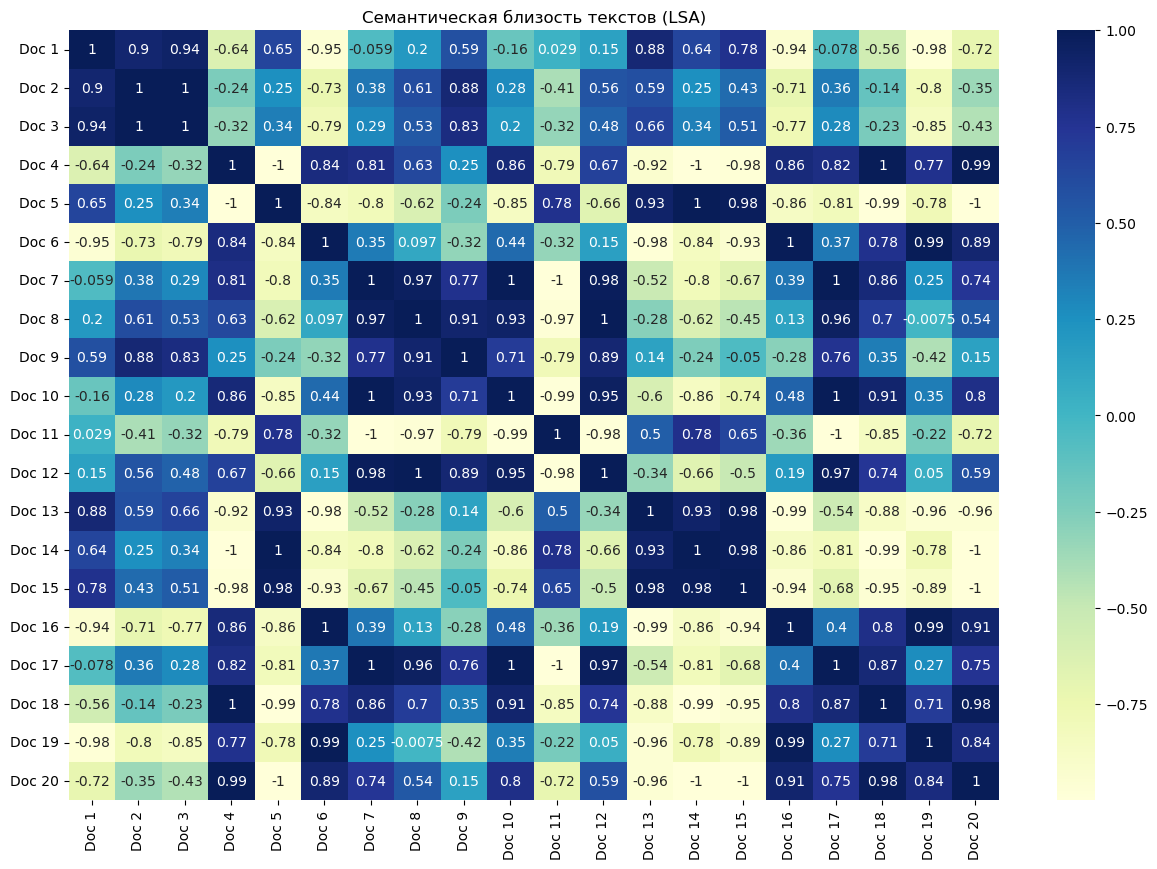

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.heatmap(df_sim, annot=True, cmap="YlGnBu")
plt.title("Семантическая близость текстов (LSA)")
plt.show()
